# GPT 4 Analysis

In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI

from token_latency_functions import (
    run_latency_experiments, 
    split_text_by_token_lengths, 
    get_token_count,
    fastest_input_token_times_fig,
    fastest_output_token_times_fig,
    preprocess_latency_data,
    quantile_regression,
    standard_linear_regression,
    plot_3d,
    save_latency_model_results
)

In [2]:
client = OpenAI()

model_name = "gpt-4-0613"

folder = f"{model_name}/"

os.makedirs(folder, exist_ok=True)

### Read in network latency constant

In [3]:
file_name = "network_latency/network_times.json"

with open(file_name, "r") as jf:
    network_times = json.load(jf)

network_latency = np.quantile(network_times, 0.1)
print("Network latency, 10% quantile:", round(network_latency, 4))

Network latency, 10% quantile: 0.1086


# Data Collection
(will overwrite existing data - skip to data analysis to read in existing data)

### 1. Varied inputs, short output

In [12]:
books_folder = "prompts/books"
texts  = []

for filename in os.listdir(books_folder):
    path = os.path.join(books_folder, filename)
    with open(path) as f:
        texts.append(f.read())

text = "\n\n".join(texts)
print(len(text))

6658611


In [13]:
token_lengths = list(range(500, 8000, 500))
prompts = split_text_by_token_lengths(text, token_lengths)

inject_message = "Now, I just want you to respond 'yes', exactly as I have it here (lowercase, no punctuation). Your response: "

messages = []
for msg in prompts:
    message = msg + inject_message
    messages.append(message)
    print(get_token_count(message))

528
1027
1528
2028
2528
3028
3528
4028
4528
5028
5528
6028
6528
7028
7527


In [14]:
run_latency_experiments(
    prompts=messages,
    client=client,
    model_name=model_name,
    iterations=50,
    csv_path=folder+"input_token_times.csv",
)

Prompt 0: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 1: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 2: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 3: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 4: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 5: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 6: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 7: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 8: 50 iterations
	Iteration 0/50
	Iteration 10/50
	Iteration 20/50
	Iteration 30/50
	Iteration 40/50
Prompt 9: 50 iterations
	Ite

In [15]:
file_name = folder + "input_token_times.csv"

input_times = pd.read_csv(file_name)

print(f"{len(input_times)} data points collected")

1500 data points collected


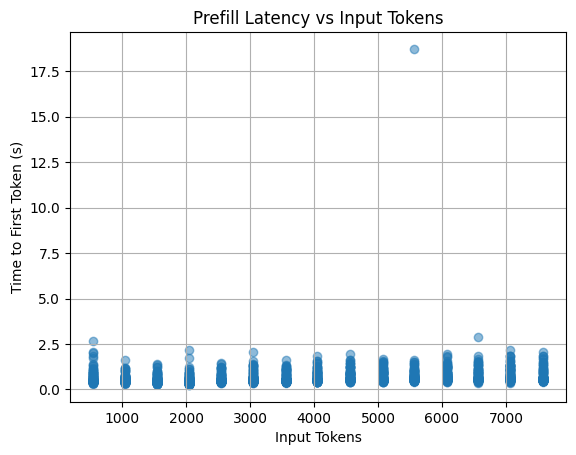

In [16]:
plt.scatter(input_times.input_tokens, input_times.prefill_latency, alpha=0.5)
plt.title("Prefill Latency vs Input Tokens")
plt.xlabel("Input Tokens")
plt.ylabel("Time to First Token (s)")
plt.grid(True)

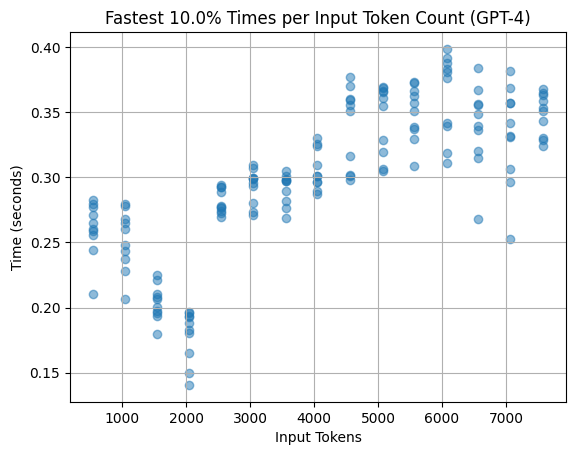

In [17]:
fastest_input_token_times_fig(
    input_times, 
    model_name="GPT-4", 
    network_latency=network_latency, 
    quantile=0.1
)

### 2. Short input, varied output

In [18]:
file_name = "prompts/prompts.json"

with open(file_name, "r") as jf:
    prompts = json.load(jf)

In [9]:
run_latency_experiments(
    prompts=prompts,
    client=client,
    model_name=model_name,
    iterations=25,
    csv_path=folder+"output_token_times.csv",
)

Prompt 0: 25 iterations
	Iteration 0/25
	Iteration 10/25
	Iteration 20/25
Prompt 1: 25 iterations
	Iteration 0/25
	Iteration 10/25
	Iteration 20/25
Prompt 2: 25 iterations
	Iteration 0/25
	Iteration 10/25
	Iteration 20/25
Prompt 3: 25 iterations
	Iteration 0/25
	Iteration 10/25
	Iteration 20/25
Prompt 4: 25 iterations
	Iteration 0/25
	Iteration 10/25
	Iteration 20/25
Prompt 5: 25 iterations
	Iteration 0/25
	Iteration 10/25
	Iteration 20/25

All done. Data written to gpt-4-0613/output_token_times.csv.


In [19]:
file_name = folder + "output_token_times.csv"

output_times = pd.read_csv(file_name)

print(f"{len(output_times)} data points collected")

150 data points collected


/home/campbellc/Documents/scripts/llm-impact-taskforce/openai-latency-regression/token_latency_functions.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fastest_10 = output_times.groupby("token_bin", group_keys=False).apply(


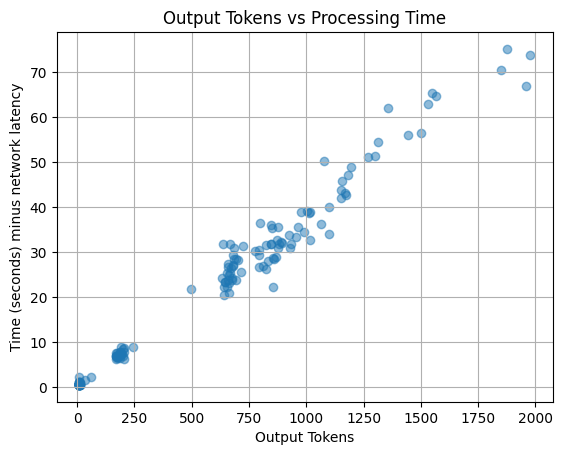

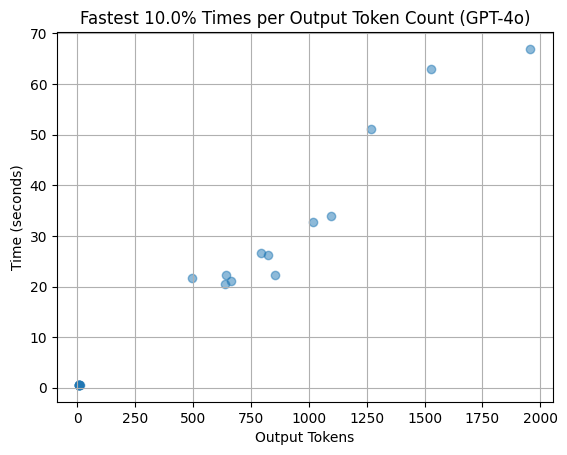

In [20]:
output_times['time_minus_network_latency'] = output_times['total_time'] - network_latency

# All times
plt.figure()
plt.scatter(output_times['output_tokens'], output_times['time_minus_network_latency'], alpha=0.5)
plt.title("Output Tokens vs Processing Time")
plt.xlabel("Output Tokens")
plt.ylabel("Time (seconds) minus network latency")
plt.grid(True)

fastest_output_token_times_fig(
    output_times,
    output_bins = range(0, 2250, 250),
    model_name = "GPT-4o",
    network_latency=network_latency,
    quantile=0.1
)

### 3. Varied input and output

In [25]:
from itertools import product
import json

token_lengths = list(range(500, 6000, 500))
prompts = split_text_by_token_lengths(text, token_lengths)

with open("prompts/prompts.json") as jf:
    instructions = json.load(jf)[4:]

combined = [f"{p} {instr}" for p, instr in product(prompts, instructions)]

output_token_limit = 4000
translate_prompts = []
for p in prompts:
    if get_token_count(p) <= output_token_limit:
        translate_prompts.append(
            "Translate the following text into German, and output only the translation:\n\n"
            + p
        )

all_prompts: list[str] = combined + translate_prompts
print(len(all_prompts))

30


In [17]:
run_latency_experiments(
    prompts=all_prompts,
    client=client,
    model_name=model_name,
    iterations=20,
    csv_path=folder+"mid_token_times.csv",
)

Prompt 0: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 1: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 2: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 3: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 4: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 5: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 6: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 7: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 8: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 9: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 10: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 11: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 12: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 13: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 14: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 15: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 16: 20 iterations
	Iteration 0/20
	Iteration 10/20
Prompt 17: 20 iterations

In [12]:
file_name = folder + "mid_token_times.csv"

mid_times = pd.read_csv(file_name)

print(f"{len(mid_times)} data points collected.")

604 data points collected.


### 4. Fill in space where there are few input tokens but many output tokens.

In [33]:
token_lengths = list(range(1000, 4000, 500))
start_text = split_text_by_token_lengths(text, token_lengths)

pres_prompts = [f"List all American presidents in order, providing at least {n} sentences about each one's presidency." for n in range(5,6)]
combined = [f"{start}.\n {instr}" for start, instr in product(start_text, pres_prompts)]

run_latency_experiments(
    prompts=combined,
    client=client,
    model_name=model_name,
    iterations=10,
    csv_path=folder+"mid_token_times.csv",
)

Prompt 0: 10 iterations
	Iteration 0/10
Prompt 1: 10 iterations
	Iteration 0/10
Prompt 2: 10 iterations
	Iteration 0/10
Prompt 3: 10 iterations
	Iteration 0/10
Prompt 4: 10 iterations
	Iteration 0/10
Prompt 5: 10 iterations
	Iteration 0/10

All done. Data written to gpt-4-0613/mid_token_times.csv.


# Data Analysis

In [4]:
file_name = folder + "combined_data.csv"

input_times = pd.read_csv(folder + "input_token_times.csv")
output_times = pd.read_csv(folder + "output_token_times.csv")
mid_times = pd.read_csv(folder + "mid_token_times.csv")

combined_data = pd.concat(
    [mid_times, input_times, output_times],
    ignore_index=True,
)

combined_data["time_minus_network_latency"] = combined_data["total_time"] - network_latency

combined_data.to_csv(file_name, index=False)
print(f"Combined data has {len(combined_data)} points")

Combined data has 2574 points


### Create long dataframe, a separate measurement for each token

In [5]:
import ast

df = combined_data.copy()
df['token_latencies'] = df['token_latencies'].apply(ast.literal_eval)
df['obs_id'] = df.index
long_df = (
    df
    .explode('token_latencies')
    .rename(columns={'token_latencies':'latency'})
    .reset_index(drop=True)
)
long_df['latency'] = long_df['latency'].astype(float)
long_df['output_tokens'] = long_df.groupby('obs_id').cumcount() + 1
long_df['total_time'] = long_df.groupby('obs_id')['latency'].cumsum()
long_df['time_minus_network_latency'] = long_df.total_time - network_latency

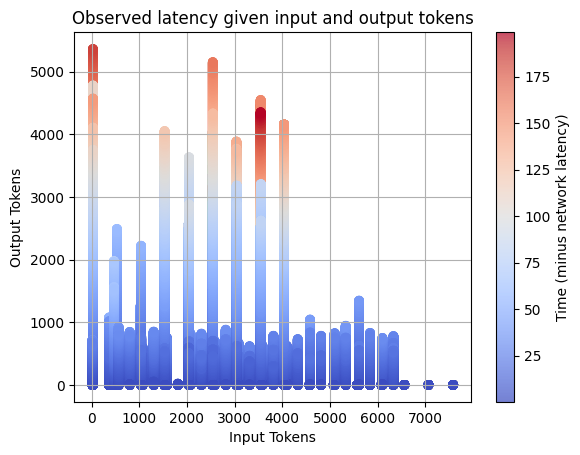

In [36]:
sc = plt.scatter(long_df["input_tokens"], long_df["output_tokens"], c=long_df["time_minus_network_latency"], cmap="coolwarm", alpha=0.7)
plt.colorbar(sc, label="Time (minus network latency)")
plt.xlabel("Input Tokens")
plt.ylabel("Output Tokens")
plt.title("Observed latency given input and output tokens")
plt.grid(True)

In [6]:
long_df[long_df.cached_tokens > 0]

,input_tokens,output_tokens,reasoning_tokens,cached_tokens,total_time,prefill_latency,latency,time_minus_network_latency,obs_id


## Quantile Regression

In [7]:
# manually take only the range where we have the most data
max_input_tokens = 4500
max_output_tokens = 5500

long_df = preprocess_latency_data(long_df, max_input_tokens, max_output_tokens)

In [8]:
quant_result, quant_loss, quant_base_loss = quantile_regression(
    long_df, 
    time_column="time_minus_network_latency",
    quantile=0.10
)

                             QuantReg Regression Results                              
Dep. Variable:     time_minus_network_latency   Pseudo R-squared:               0.7515
Model:                               QuantReg   Bandwidth:                      0.3214
Method:                         Least Squares   Sparsity:                        11.43
Date:                        Thu, 10 Jul 2025   No. Observations:               775761
Time:                                10:48:58   Df Residuals:                   775757
                                                Df Model:                            3
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2743      0.008     32.558      0.000       0.258       0.291
in_k          -0.0830      0.004    -21.174      0.000      -0.091      -0.075
out_k         22.0867      0.005   4463.043      0.000      22.077      22.

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(long_df[['in_k', 'out_k', 'in_out_k']])

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

    feature       VIF
0     const  6.600648
1      in_k  2.755964
2     out_k  2.933127
3  in_out_k  5.299143


In [10]:
fig = plot_3d(
    long_df,
    model=quant_result,
    title="Quantile Regression (10th percentile)",
    observed_z_col="time_minus_network_latency"
)
fig.write_html(folder + "quant_reg_surface.html")

In [11]:
fig.show()

## Ordinary Least Squares

In [12]:
ols_result, mse, mse_base = standard_linear_regression(
    long_df, 
    time_column="time_minus_network_latency"
)

                                OLS Regression Results                                
Dep. Variable:     time_minus_network_latency   R-squared:                       0.960
Model:                                    OLS   Adj. R-squared:                  0.960
Method:                         Least Squares   F-statistic:                 6.136e+06
Date:                        Thu, 10 Jul 2025   Prob (F-statistic):               0.00
Time:                                10:49:22   Log-Likelihood:            -2.5902e+06
No. Observations:                      775761   AIC:                         5.180e+06
Df Residuals:                          775757   BIC:                         5.180e+06
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [13]:
fig = plot_3d(
    long_df,
    model=ols_result,
    title="Ordinary Least Squares Regression",
    observed_z_col="time_minus_network_latency"
)
fig.write_html(folder + "ols_surface.html")

In [14]:
fig.show()

## Save coefficients

In [15]:
coeff_df = save_latency_model_results(
    quant_result, 
    quant_loss, 
    quant_base_loss, 
    ols_result, 
    mse, 
    mse_base, 
    model_name=model_name
)

Results saved to latency_coefficients.csv
